In [3]:
import nltk
import numpy as np
import enchant
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')      
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Micha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Micha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Micha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Micha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Micha\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [2]:
data = []
# ścieżka do plików wrzućcie rozpakowane dane do folderu 'data' w tym samym folderze co jest ipynb
p = os.getcwd()+'\data'
for folder in os.listdir(p):
    mails = os.listdir(p + '/' + folder)
    for mail in mails:
        path = p + '/' + folder + '/' + mail
        with open(path) as file:
            text = file.read()
        data.append([text, folder])
df = pd.DataFrame(data)

In [3]:
def Preprocesing(data, lematize = True, stem = True):
    # Korzystamy naraz z lematyzacji i stemmingu by osiągnąć jak największą redukcje słów
    
    # Bierzemy wszystko po pierwszych 2 enterach czyli po opisie technicznym
    formated = data.split('\n\n')[1:]
    formated = ' '.join(formated).lower() # zamiana na małe litery
    
    # Wyrzucamy wszystkie wyrażenia słowo.słowo(ścieżki itp.) i adresy mail 
    formated = re.sub('((\w+\.)+\w+)|\w+@\w+','', formated)
    
    # Podmieniamy wszystkie liczby, ciągi liczb na spacje  i "_"
    formated =re.sub('\W|\d|_'," ", formated)
    
    # Tokenizacja
    tokenizer = RegexpTokenizer(r"\w+")
    formated= tokenizer.tokenize(formated)
    
    # Usuwamy stop wordsy
    stop_words = set(stopwords.words('english'))
    formated = [word for word in formated if (not word in stop_words) and len(word) > 1]
        
    # Lematyzacja
    if(lematize == True):
        lemmatizer = WordNetLemmatizer()
        formated = [lemmatizer.lemmatize(word) for word in formated] 
        
    # Stemming    
    if (stem == True):
        ps = PorterStemmer() 
        formated = [ps.stem(word) for word in formated]           

    return " ".join(formated)

In [4]:
from sklearn.model_selection import train_test_split

df = pd.DataFrame(data)

X_train, X_test, y_train, y_test = train_test_split(
    df[0],
    df[1],
    test_size=0.4, random_state=213)

# Preprocesing
X_train = [Preprocesing(text) for text in X_train]
X_test = [Preprocesing(text) for text in X_test]
X_train[:5]

['mitchel todd write articl com lanc visser write wait investig consid everyon dead place burnt ground guess honest citizen take word atf much threat peopl look histori koresh folow captur mount carmel complex year ago gun battl rival bd sect leav one person dead exactli peac love bunch wonder get mi inform straight batf koresh follow captur compound year ago alway year ago argument lead group gunfight erupt one person die koresh charg murder sheriff came arrest sheriff knock dorr show koresh warrant tactic batf might tri learn koresh other charg peacibl surrend sherrif trial ensu other found innoc juri hung koresh charg mob rule prettier mere mob call govern chariti use someon els money wilson theori rel go back far enough relat',
 'okay got enough repli kubota kenai denali system post summari capabl graphic transform modul frame buffer modul frame buffer bit bit doubl buffer doubl buffer buffer bit bit alpha stencil bit bit paul martz mean either alpha stencil simultan stereo support

# Tf_idf + Kmeans

In [5]:
def Tf_idf(data, max_t = 0.20, min_t = 0.02):
    # obliczamy tf_idf i usuwamy słowa które występują w mniej niż 2% tesktów i częściej niż w 20%
    
    vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', max_df = max_t,min_df=min_t)
    tf_idf = vectorizer.fit_transform(data)
    tf_idf = pd.DataFrame(tf_idf.toarray(), columns = vectorizer.get_feature_names_out())
    return tf_idf, vectorizer

In [6]:
tf_idf, vectorizer = Tf_idf(X_train)
used_words = vectorizer.get_feature_names_out()
tf_idf

,abil,abl,absolut,accept,access,accord,account,act,action,activ,...,world,wors,worth,written,wrong,wrote,ye,year,york,young
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.190352,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.232458,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11993,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.193387,0.000000,0.0,0.0
11994,0.0,0.0,0.0,0.105819,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.134014,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
11995,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
11996,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


Jak widzimy według DBSCAN nasze dane to głównie szum

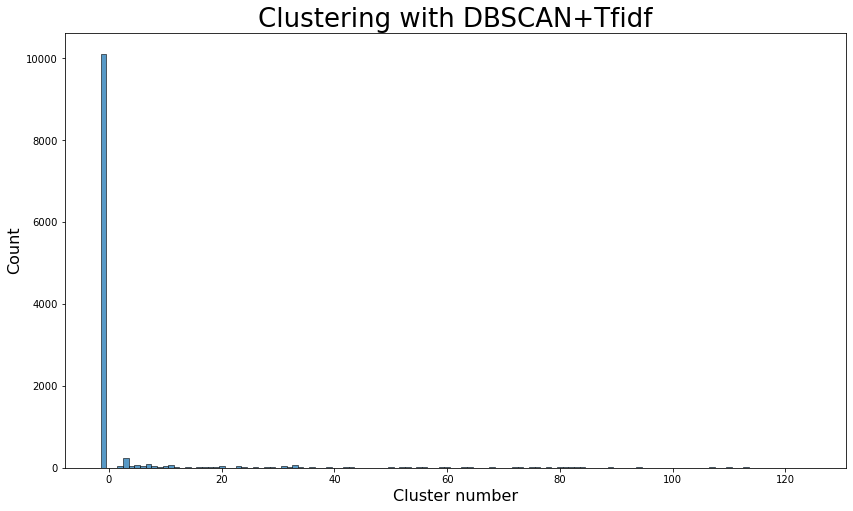

In [7]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps =0.9).fit(tf_idf)
labels = clustering.labels_
plt.figure(figsize=(14,8)).clf()
sns.histplot(labels, discrete= True)
plt.title("Clustering with DBSCAN+Tfidf",fontsize=26)
plt.xlabel('Cluster number',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.show()

In [8]:
# Liczenie dowolnego score dla różnych ilości klastrów i modeli
def count_clustering_scores(X, cluster_num, model, score_fun):
    # Napiszmy tę funkcje tak ogólnie, jak to możliwe. 
    # Zwróćcie uwagę na przekazanie obiektów typu callable: model i score_fun.
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

In [9]:
cluster_num_seq = range(5, 36) # Niektóre metryki nie działają gdy mamy tylko jeden klaster
silhouette_vec = count_clustering_scores(tf_idf, cluster_num_seq, KMeans, silhouette_score)

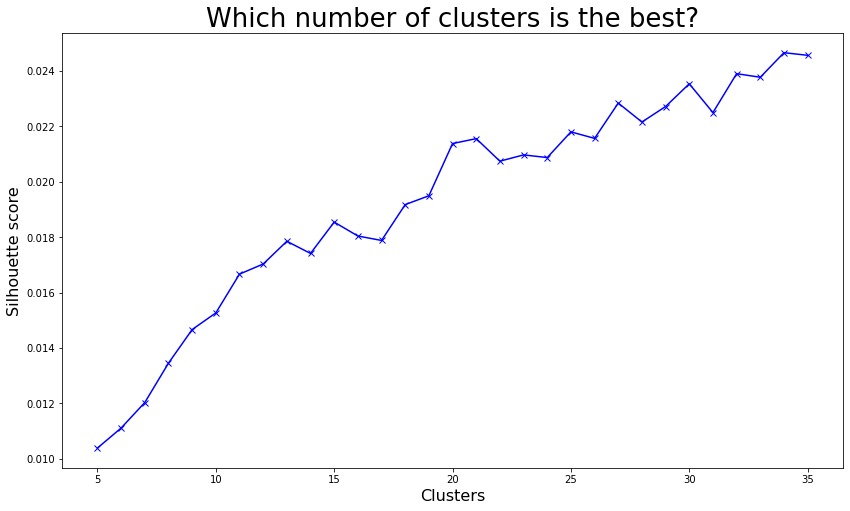

In [10]:
plt.figure(figsize=(14,8)).clf()
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.title("Which number of clusters is the best?",fontsize=26)
plt.xlabel('Clusters',fontsize=16)
plt.ylabel('Silhouette score',fontsize=16)

plt.show()

In [11]:
# Do liczenia sum of squares dla elbow method
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

In [12]:
wcss_vec = count_wcss_scores(tf_idf, len(cluster_num_seq))
x_ticks = list(range(1, len(wcss_vec) + 1))

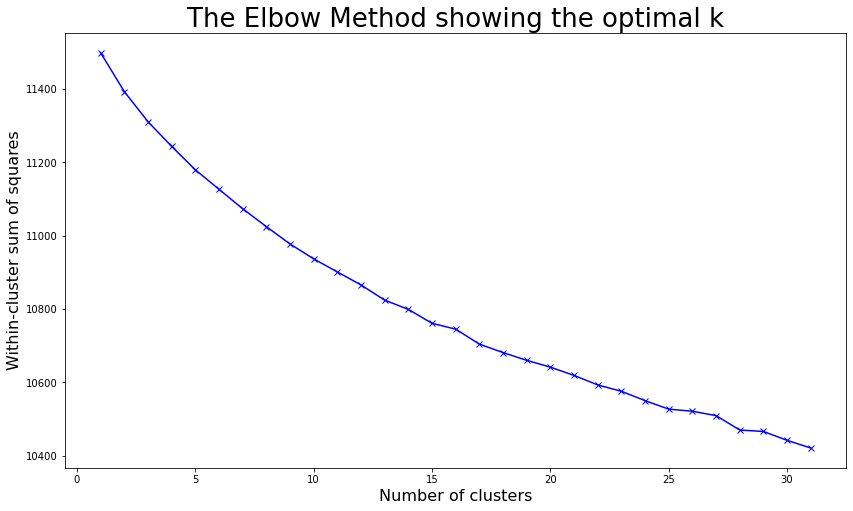

In [13]:

plt.figure(figsize=(14,8)).clf()
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('Number of clusters',fontsize=16)
plt.ylabel('Within-cluster sum of squares',fontsize=16)
plt.title('The Elbow Method showing the optimal k',fontsize=26)
plt.show()

Widać, że nie ma jakiegoś wyróżniającego się punktu, ale po 12 jest pierwszy spadek w Silhouette score. Chcemy mieć stosunkowo niewiele więc 12 jest najlepszą liczbą.

In [14]:
true_k = 12
km = KMeans(n_clusters = true_k)
km.fit(tf_idf)
labels = km.predict(tf_idf)

In [15]:
# Tworzenie crosstaba dla poglądu interpretowalności clusteringu
df = pd.DataFrame({'label': labels, 'category': y_train})
pd.crosstab(df['label'], df['category']).T

label,0,1,2,3,4,5,6,7,8,9,10,11
category,,,,,,,,,,,,
alt.atheism,0,1,157,3,0,12,3,2,139,0,169,132
comp.graphics,0,2,289,1,1,155,123,4,0,30,1,4
comp.os.ms-windows.misc,0,3,163,1,17,61,108,0,1,252,0,3
comp.sys.ibm.pc.hardware,0,4,261,3,126,118,17,2,0,58,1,0
comp.sys.mac.hardware,0,4,362,0,82,110,10,3,0,16,0,0
comp.windows.x,0,12,244,0,1,107,70,0,0,160,1,3
misc.forsale,2,2,338,20,65,142,7,26,3,14,0,0
rec.autos,2,1,211,301,18,44,1,0,15,4,0,0
rec.motorcycles,285,3,210,17,21,31,0,4,28,5,1,0


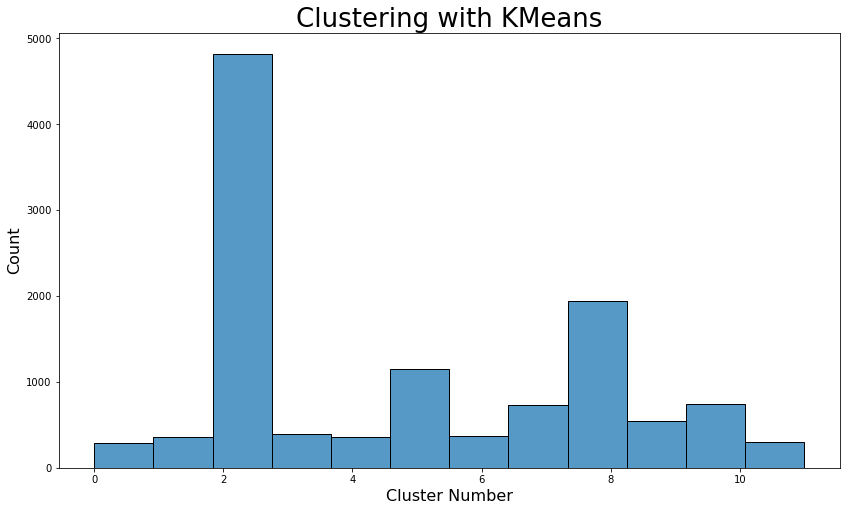

In [16]:
plt.figure(figsize=(14,8)).clf()
sns.histplot(labels, bins = true_k)
plt.title('Clustering with KMeans',fontsize=26)
plt.ylabel('Count',fontsize=16)
plt.xlabel('Cluster Number',fontsize=16)
plt.show()

Centroidy powiedzą nam jakie słowa są najważniejsze dla danego klastru

In [17]:
centroids = km.cluster_centers_.argsort()[:, ::-1] 
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in centroids[i, :15]:
        print(' %s' % terms[ind], end='')
        
    print()

Cluster 0: bike ride dod road turn right mile left need new buy com thing engin good
Cluster 1: key encrypt chip clipper secur govern phone public bit law messag david number com commun
Cluster 2: work com new problem look good anyon need year comput want tri univers thing post
Cluster 3: car engin speed look model good drive new year price mile buy power realli light
Cluster 4: drive disk hard mb control problem work mac format thank softwar need instal card comput
Cluster 5: thank pleas mail anyon advanc email hi appreci repli post address help send list look
Cluster 6: file format window imag program convert ftp thank run work display help pc look tri
Cluster 7: game team player play year win fan season basebal leagu good goal hit run best
Cluster 8: govern right gun state law kill child israel fbi said jew claim way year believ
Cluster 9: window driver run card program problem thank applic version work anyon display graphic manag screen
Cluster 10: god christian jesu believ christ 

### Jak widzimy nawet Kmeans ma problem z tworzeniem się jednego dużego klastra. Zatem zmieniamy podejście i będziemy robić topic modeling i na jego podstawie clustering.

In [18]:
# Funkcja służąca do dostania najważniejszych słów z tematów
def get_topics(model,num_topics, feat_names, n_top_words = 10):
    word_dict = {};
    
    for i in range(num_topics):
        # z składowych modeli redukcji sortujemy je po ważności i wybieramy n pierwszych
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict).T;

## Redukcja po NMF

In [19]:
# Ustalimy 15 jako stałą liczbe tematów dla wszystkich metod
true_k= 15

In [42]:
model = NMF(n_components = true_k, init = 'nndsvda', max_iter = 1000, random_state = 42)
model.fit(tf_idf)
features = model.transform(tf_idf)
# Tabela najważniejszych słów dla danego tematu
get_topics(model, true_k, used_words)

,0,1,2,3,4,5,6,7,8,9
Topic # 01,right,govern,gun,state,law,kill,said,child,fbi,way
Topic # 02,window,run,program,problem,applic,manag,version,display,driver,screen
Topic # 03,game,team,play,player,year,win,fan,season,basebal,leagu
Topic # 04,god,christian,jesu,believ,bibl,christ,faith,exist,church,love
Topic # 05,drive,disk,hard,mb,control,problem,work,mac,instal,format
Topic # 06,thank,pleas,mail,anyon,advanc,post,email,appreci,hi,repli
Topic # 07,key,chip,encrypt,clipper,secur,bit,phone,public,govern,number
Topic # 08,car,bike,engin,ride,dod,speed,look,good,buy,mile
Topic # 09,card,driver,video,monitor,bit,color,mb,problem,board,work
Topic # 10,file,imag,format,program,convert,ftp,display,graphic,disk,color


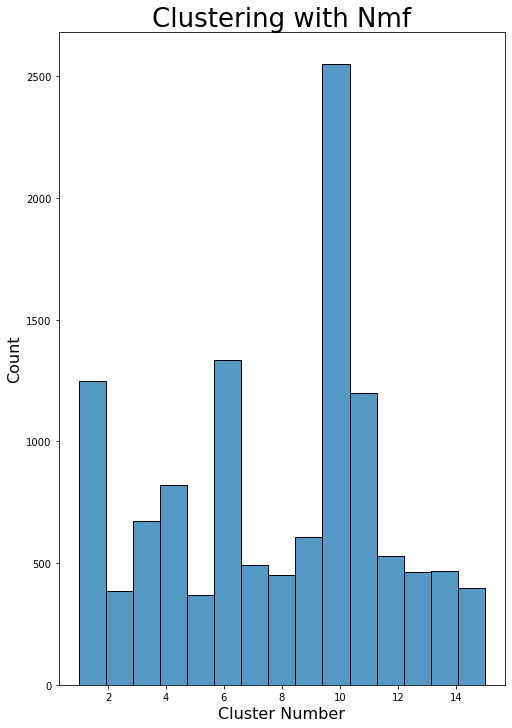

In [21]:
# Przypisujemy najważniejszy temat jako klaster 
topic = [np.argmax(values)+1 for values in features]

plt.figure(figsize=(8,12)).clf()
topics = pd.DataFrame({'Clusters' : topic})

# Tworzymy histogram by sprawdzić jak metoda radzi sobie z nadmiernym skupianiem się wokół jednego klastra
sns.histplot(topics, bins = true_k, x = 'Clusters')
plt.title('Clustering with Nmf',fontsize=26)
plt.ylabel('Count',fontsize=16)
plt.xlabel('Cluster Number',fontsize=16)
plt.show()

## Redukcja po LDA

In [22]:
lda = LDA(n_components=true_k, random_state=42)
lda.fit(tf_idf)
lda_features = lda.transform(tf_idf)
get_topics(lda, true_k, used_words)

,0,1,2,3,4,5,6,7,8,9
Topic # 01,key,encrypt,chip,clipper,secur,phone,govern,bit,public,david
Topic # 02,object,theori,scienc,valu,caus,test,effect,observ,fact,thing
Topic # 03,univers,space,internet,research,michael,program,tax,scienc,bitnet,institut
Topic # 04,fbi,koresh,gun,ga,start,weapon,child,claim,day,believ
Topic # 05,blue,trade,red,period,st,tom,play,shot,season,york
Topic # 06,window,file,card,run,problem,work,program,driver,color,imag
Topic # 07,monitor,anyon,heard,day,price,thank,drop,month,box,deal
Topic # 08,car,bike,dod,ride,engin,new,good,look,drive,road
Topic # 09,cost,space,design,price,project,high,ground,market,expens,build
Topic # 10,thank,pleas,mail,anyon,email,post,appreci,list,hi,inform


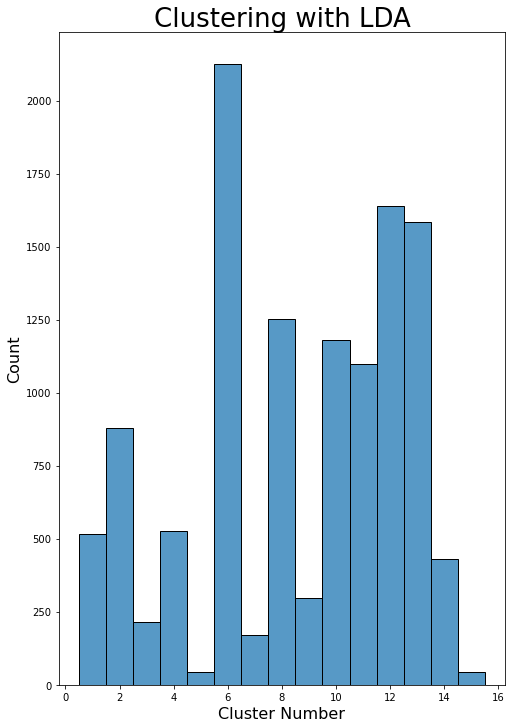

In [23]:
topic = [np.argmax(values)+1 for values in lda_features]
topic = pd.DataFrame({'Clusters' : topic})

plt.figure(figsize=(8,12)).clf()
sns.histplot(topic, bins = true_k, x = 'Clusters', discrete = True)
plt.title('Clustering with LDA',fontsize=26)
plt.ylabel('Count',fontsize=16)
plt.xlabel('Cluster Number',fontsize=16)
plt.show()

## Redukcja po SVD

In [24]:
svd = TruncatedSVD(n_components=true_k, random_state=42)
svd.fit(tf_idf)
svd_features = svd.transform(tf_idf)
get_topics(svd,true_k,used_words)

,0,1,2,3,4,5,6,7,8,9
Topic # 01,work,year,good,right,anyon,window,look,want,thank,problem
Topic # 02,window,thank,file,card,drive,program,mail,driver,run,pleas
Topic # 03,game,team,year,play,player,win,fan,season,basebal,hit
Topic # 04,window,god,game,file,christian,jesu,team,program,win,bibl
Topic # 05,key,window,govern,encrypt,file,chip,program,clipper,secur,public
Topic # 06,mail,thank,pleas,anyon,post,email,key,list,send,address
Topic # 07,key,drive,chip,god,game,encrypt,card,bit,disk,mb
Topic # 08,car,key,god,chip,bike,encrypt,bit,engin,good,jesu
Topic # 09,card,monitor,video,driver,bit,color,graphic,price,board,anyon
Topic # 10,object,valu,moral,scienc,imag,space,program,univers,comput,frank


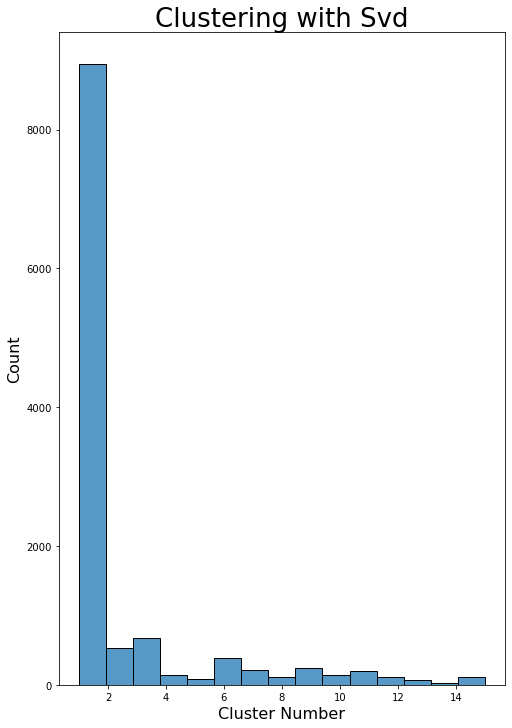

In [25]:
topic = [np.argmax(values)+1 for values in svd_features]
plt.figure(figsize=(8,12)).clf()
topic = pd.DataFrame({'Clusters' : topic})
sns.histplot(topic, bins = true_k, x = 'Clusters')
plt.title('Clustering with Svd',fontsize=26)
plt.ylabel('Count',fontsize=16)
plt.xlabel('Cluster Number',fontsize=16)
plt.show()

## Zatem NMF radzi sobie najlepiej z rozbijaniem na wmiare równomierne klastry. Czy warto robić na tym klasyczne klastrowanie?

In [26]:
km = KMeans(n_clusters = 15)
km.fit(features)
labels = km.predict(features)

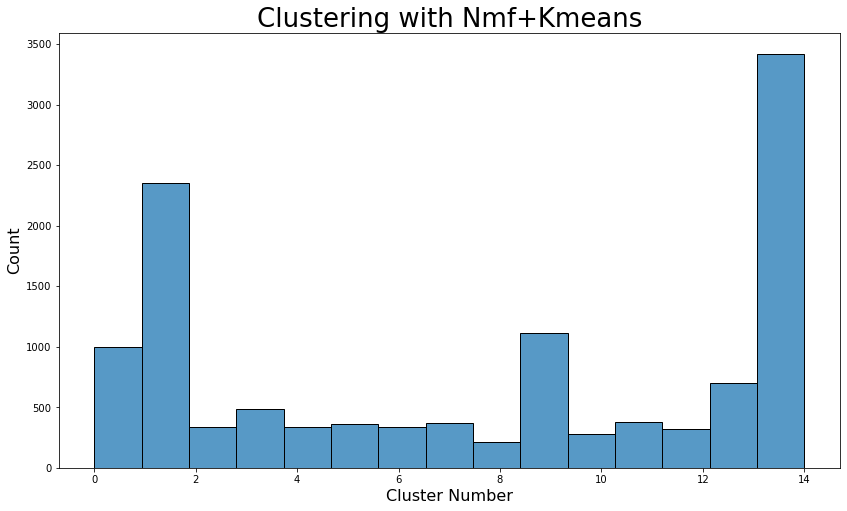

In [27]:
plt.figure(figsize=(14,8)).clf()
sns.histplot(labels, bins = 15)
plt.title('Clustering with Nmf+Kmeans',fontsize=26)
plt.ylabel('Count',fontsize=16)
plt.xlabel('Cluster Number',fontsize=16)
plt.show()

Nie dość, że przy tym tracimy na interpretowalności to uwydatnia się problem z jednym dużym klastrem

## Lepiej działa klastrowanie wokół nowych osi. Jaka liczba klastrów będzie najlepsza?

In [43]:
scores = []  
cluster_num_iter = range(5,36,1)

# ta sama metoda którą używaliśmy przy pierwszym KMeans
for k in cluster_num_iter:
    model = NMF(n_components = k, init = 'nndsvda', max_iter = 1000, random_state = 42)
    model.fit(tf_idf)
    nmf_features = model.transform(tf_idf)
    topic = [np.argmax(values)+1 for values in nmf_features]
    wcss = silhouette_score(tf_idf, topic)
    scores.append(wcss)

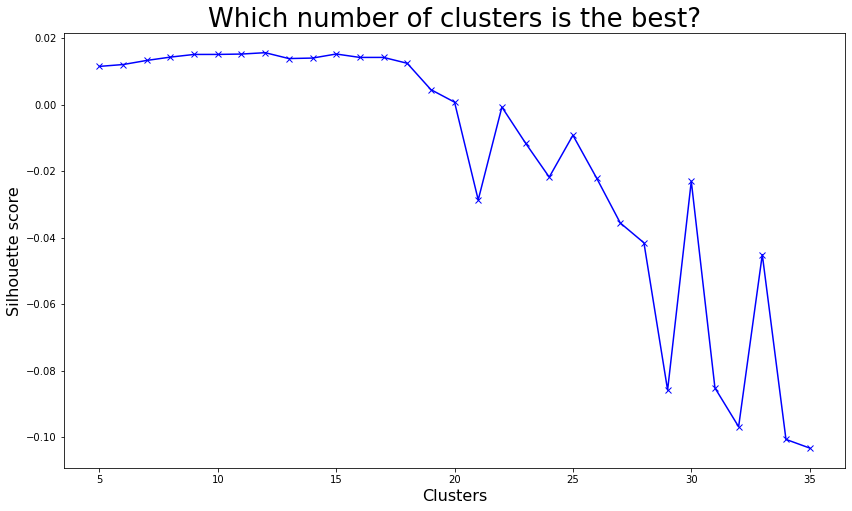

In [44]:
plt.figure(figsize=(14,8)).clf()
plt.plot(cluster_num_seq, scores, 'bx-')
plt.title("Which number of clusters is the best?",fontsize=26)
plt.xlabel('Clusters',fontsize=16)
plt.ylabel('Silhouette score',fontsize=16)
plt.show()

# Implementacja
Widzimy, że 12 jest niezłym kandydatem na ogólniejszy clustering, a dla szczególniejszego przypadku to 25

In [48]:
def Implement(tf_idf, words, model, true_k, y):
    
    model.fit(tf_idf)
    df_topic = get_topics(model,true_k,words,15)
    
    features = model.transform(tf_idf)
    
    topic = [np.argmax(values)+1 for values in features]
    df = pd.DataFrame({'topic': topic, 'category': y})
    cross_tab = pd.crosstab(df['topic'], df['category']).T
    cross_tab = cross_tab.apply(lambda row : round(100*row/sum(row), 2), axis = 1)
    
    plt.figure(figsize=(14,8)).clf()
    topic = pd.DataFrame({'Cluster Number' : topic})
    plot = sns.histplot(topic, bins = true_k, x = 'Cluster Number', discrete = True)
    plt.ylabel('Count',fontsize=16)
    plt.xlabel('Cluster Number',fontsize=16)
    plt.title('Clustering with Nmf on train',fontsize=26)
    
    return df_topic, cross_tab, plot, model

In [ ]:
# np.argmax(scores)+5 
# Trzeba za każdym razem liczyc Silhouette score, więc darujmy sobie. Zawsze wychodzi 12

In [5]:
true_k = 12
model = NMF(n_components = true_k, init = 'nndsvda', max_iter = 500, random_state = 42)
topics, cross_tab, plot, final_model = Implement(tf_idf, used_words, model,true_k, y_train)

NameError: name 'Implement' is not defined

In [ ]:
topics

In [2]:
plt.figure(figsize=(18,14)).clf()
sns.heatmap(cross_tab, annot = cross_tab, cmap='Blues')
plt.ylabel('Newsgroup', fontsize=16)
plt.yticks(rotation=0)
plt.xlabel('Cluster', fontsize=16)
plt.title("Confusion matrix on train (% of group in cluster)", fontsize=26)
plt.show()

NameError: name 'plt' is not defined

## Wdrożenie testu

In [32]:
tf_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = tf_idf.columns)

In [33]:
# Model ma być wytrenowany już w tej funkcji
def CheckTest(model, tf, true_k, y):
    
    features = model.transform(tf)
    
    topic = [np.argmax(values)+1 for values in features]
    df = pd.DataFrame({'topic': topic, 'category': y})
    
    cross_tab = pd.crosstab(df['topic'], df['category']).T
    # Taki sam cross_tab jak ostatnio tylko teraz z procentami zamiast liczb
    cross_tab = cross_tab.apply(lambda row : round(100*row/sum(row), 2), axis = 1)
    
    plt.figure(figsize=(14,8)).clf()
    topic = pd.DataFrame({'Cluster Number' : topic})
    plot = sns.histplot(topic, bins = true_k, x = 'Cluster Number', discrete = True)
    plt.ylabel('Count',fontsize=16)
    plt.xlabel('Cluster Number',fontsize=16)
    plt.title('Clustering with Nmf on test',fontsize=26)

    return cross_tab, plot

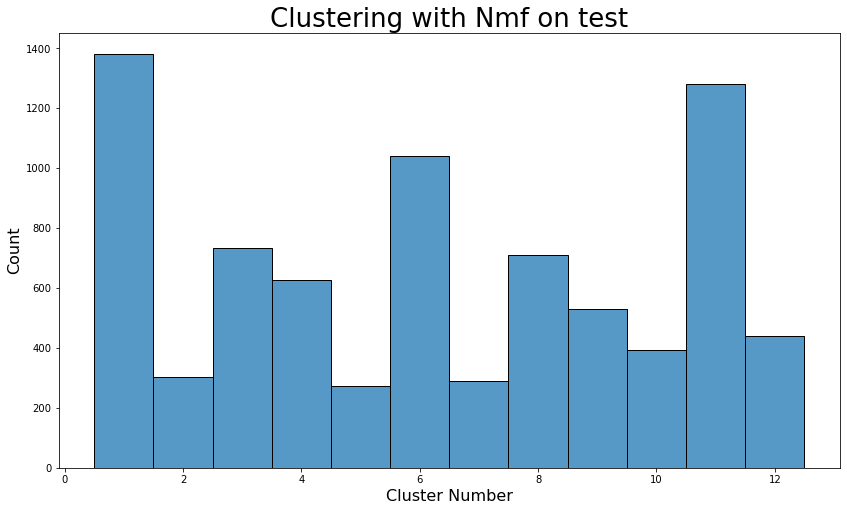

In [34]:
cross_tab, hist_plot = CheckTest(final_model, tf_test, true_k, y_test)

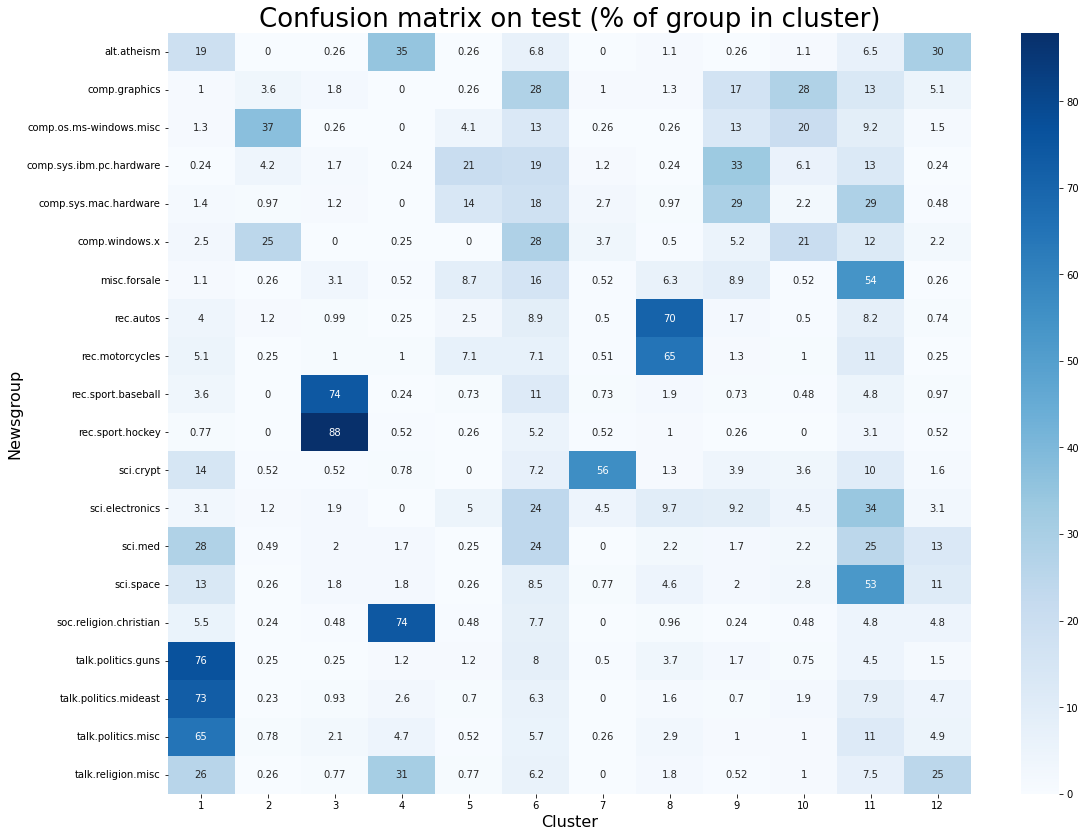

In [35]:
plt.figure(figsize=(18,14)).clf()
sns.heatmap(cross_tab, annot = cross_tab, cmap='Blues')
plt.ylabel('Newsgroup', fontsize=16)
plt.yticks(rotation=0)
plt.xlabel('Cluster', fontsize=16)
plt.title("Confusion matrix on test (% of group in cluster)", fontsize=26)
plt.show()

## Spróbujmy znaleźć tematy dla ograniczonego zbioru do grup polityczno-religijnych

In [37]:
limited = ['talk.politics.misc',
            'talk.politics.guns',
            'talk.politics.mideast',
            'talk.religion.misc',
            'alt.atheism',
            'soc.religion.christian']

data_l = [text for text, group in zip(X_train, y_train) if group in limited]
y_l = [group for group in y_train if group in limited]

In [38]:
tf_idf_l, vectorizer_l = Tf_idf(data_l)
used_words_l = vectorizer_l.get_feature_names_out()

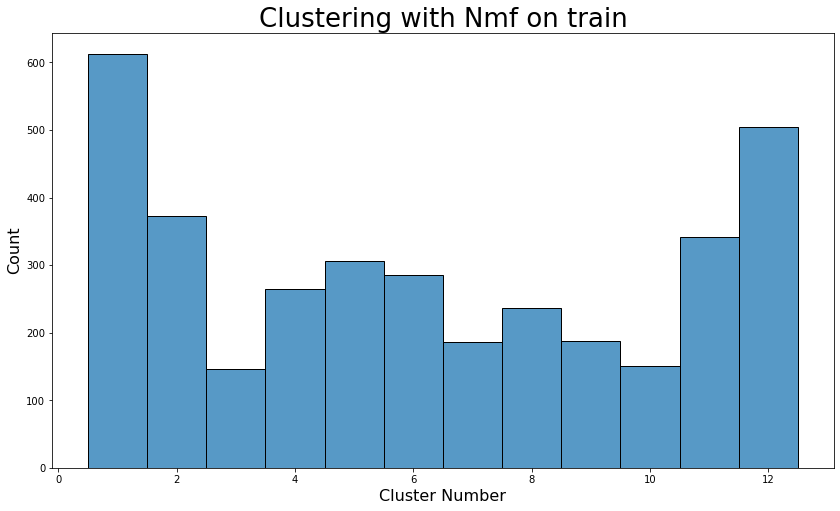

In [39]:
topics_l, cross_tab_l, plot_l, final_model_l = Implement(tf_idf_l, used_words_l, model, y_l)

In [40]:
topics_l

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Topic # 01,post,govern,year,univers,presid,law,american,new,parti,nation,group,read,clinton,pleas,constitut
Topic # 02,fbi,koresh,batf,bd,compound,ga,start,child,atf,davidian,tank,agent,build,claim,cult
Topic # 03,armenian,turkish,armenia,turk,genocid,turkey,soviet,extermin,russian,serdar,mountain,road,muslim,argic,villag
Topic # 04,moral,object,valu,frank,dwyer,uucp,better,absolut,scienc,realiti,truth,observ,subject,jon,keith
Topic # 05,israel,isra,arab,jew,palestinian,jewish,peac,kill,occupi,attack,land,territori,soldier,polici,war
Topic # 06,gun,weapon,law,firearm,crimin,control,crime,kill,shoot,polic,death,arm,carri,rate,defens
Topic # 07,homosexu,cramer,clayton,gay,men,com,sexual,sex,uunet,number,studi,relat,straight,child,woman
Topic # 08,theori,evolut,scienc,exist,creation,religion,predict,observ,andi,jim,origin,scientif,model,univers,evid
Topic # 09,abort,pay,insur,health,tax,care,fund,privat,money,cost,reduc,child,feder,servic,program
Topic # 10,muslim,islam,jew,religion,law,world,nazi,countri,religi,war,ethnic,edu,jewish,jon,true


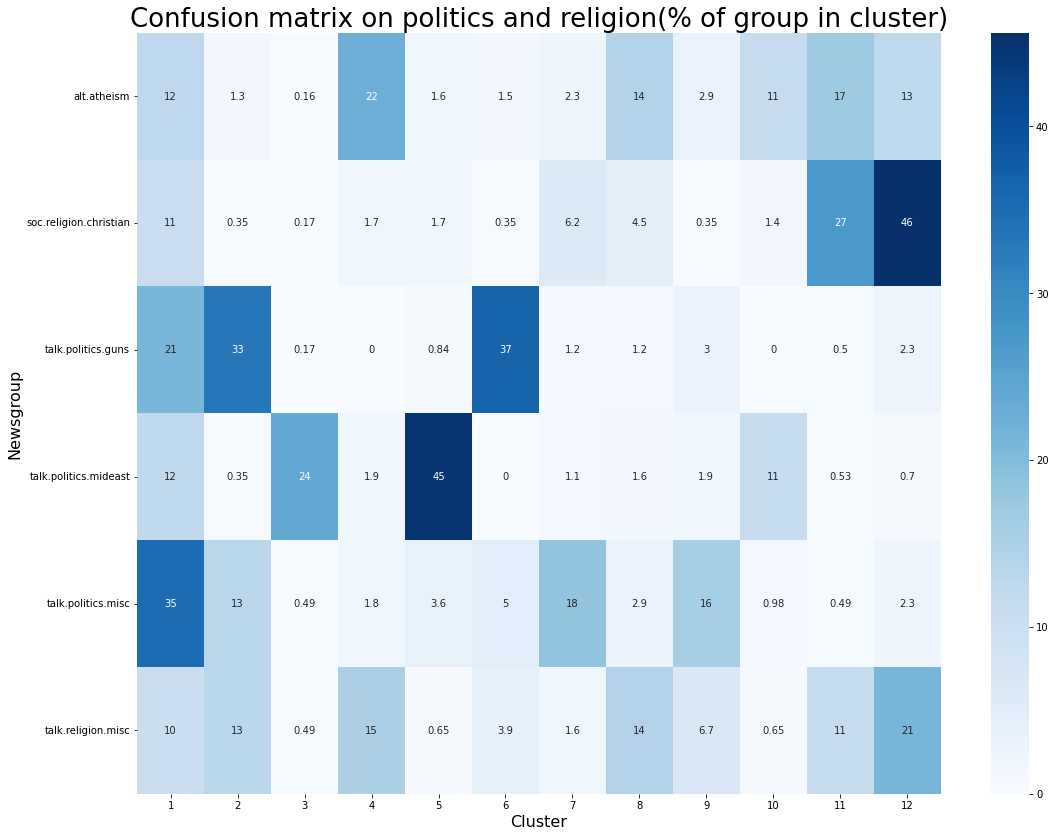

In [41]:
plt.figure(figsize=(18,14)).clf()
sns.heatmap(cross_tab_l, annot = cross_tab_l, cmap='Blues')
plt.ylabel('Newsgroup', fontsize=16)
plt.yticks(rotation=0)
plt.xlabel('Cluster', fontsize=16)
plt.title("Confusion matrix on politics and religion(% of group in cluster)", fontsize=26)
plt.show()